In [12]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from train import ToxicClassifier
import pandas as pd
import numpy as np
import seaborn as sns


In [13]:
def extract_embeddings(model, inputs):
    model.eval()
    with torch.no_grad():
        embeddings = model(inputs)
    return embeddings


In [14]:
def plot_tsne_graph(embeddings, labels):
    tsne = TSNE(n_components=2, random_state=42, perplexity=2)  # Adjust perplexity as needed
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='rainbow')
    plt.colorbar()
    plt.show()


In [15]:
def get_model(checkpoint_path, device="cpu"):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    config = checkpoint["config"]
    print(config)
    model = ToxicClassifier(config)
    model.load_state_dict(checkpoint["state_dict"])
    return model

In [16]:
checkpoint_path = '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/ALBERT-Primary/lightning_logs/version_0/checkpoints/converted/epoch=3.ckpt'
model = get_model(checkpoint_path)

{'name': 'ALBERT-Primary', 'n_gpu': 2, 'batch_size': 8, 'accumulate_grad_batches': 10, 'loss': 'binary_cross_entropy', 'arch': {'type': 'ALBERT', 'args': {'num_classes': 6, 'model_type': 'albert-base-v2', 'model_name': 'AlbertForSequenceClassification', 'tokenizer_name': 'AlbertTokenizer'}, 'freeze_bert': False, 'from_detoxify': False}, 'dataset': {'type': 'JigsawData', 'args': {'train': {'secondary_positive': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/training_data/train_secondary_positive.csv', 'secondary_neutral': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/training_data/train_secondary_neutral.csv', 'jigsaw': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/training_data/train_jigsaw.csv'}, 'val': {'secondary_positive': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/training_data/val_secondary_positive.csv', 'secondary_neutral': '/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.weight', 'predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

From Detoxify Layers: False


In [17]:
input_pd = pd.read_csv('/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/training_data/test_jigsaw.csv').sample(2, random_state=42)
inputs = input_pd["comment_text"].to_list()
labels = input_pd.iloc[:, 2:8].max(axis=1).tolist()

In [18]:
tokenized_inputs = model.tokenizer(
    inputs, return_tensors="pt", truncation=True, padding=True
).to("cpu")

In [19]:
outputs = model.model(**tokenized_inputs, output_hidden_states=True,return_dict=True)

In [20]:
def visualize_layerwise_embeddings(hidden_states, masks, labels, epoch, title, layers_to_visualize):
    dim_reducer = TSNE(n_components=2, random_state=42, perplexity=2)
    num_layers = len(layers_to_visualize)

    fig = plt.figure(figsize=(24, (num_layers // 4) * 6))
    ax = [fig.add_subplot(num_layers // 4, 4, i + 1) for i in range(num_layers)]

    if not isinstance(labels, np.ndarray):
        labels = np.array(labels)

    for i, layer_i in enumerate(layers_to_visualize):
        layer_embeds = hidden_states[layer_i]

        layer_averaged_hidden_states = torch.div(
            layer_embeds.sum(dim=1), masks.sum(dim=1, keepdim=True))
        layer_dim_reduced_embeds = dim_reducer.fit_transform(
            layer_averaged_hidden_states.detach().numpy())  # Use detach() here

        df = pd.DataFrame.from_dict(
            {'x': layer_dim_reduced_embeds[:, 0], 'y': layer_dim_reduced_embeds[:, 1], 'label': labels})

        sns.scatterplot(data=df, x='x', y='y', hue='label', ax=ax[i])

        plt.savefig('/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/tsne_plot.png')


ValueError: perplexity must be less than n_samples

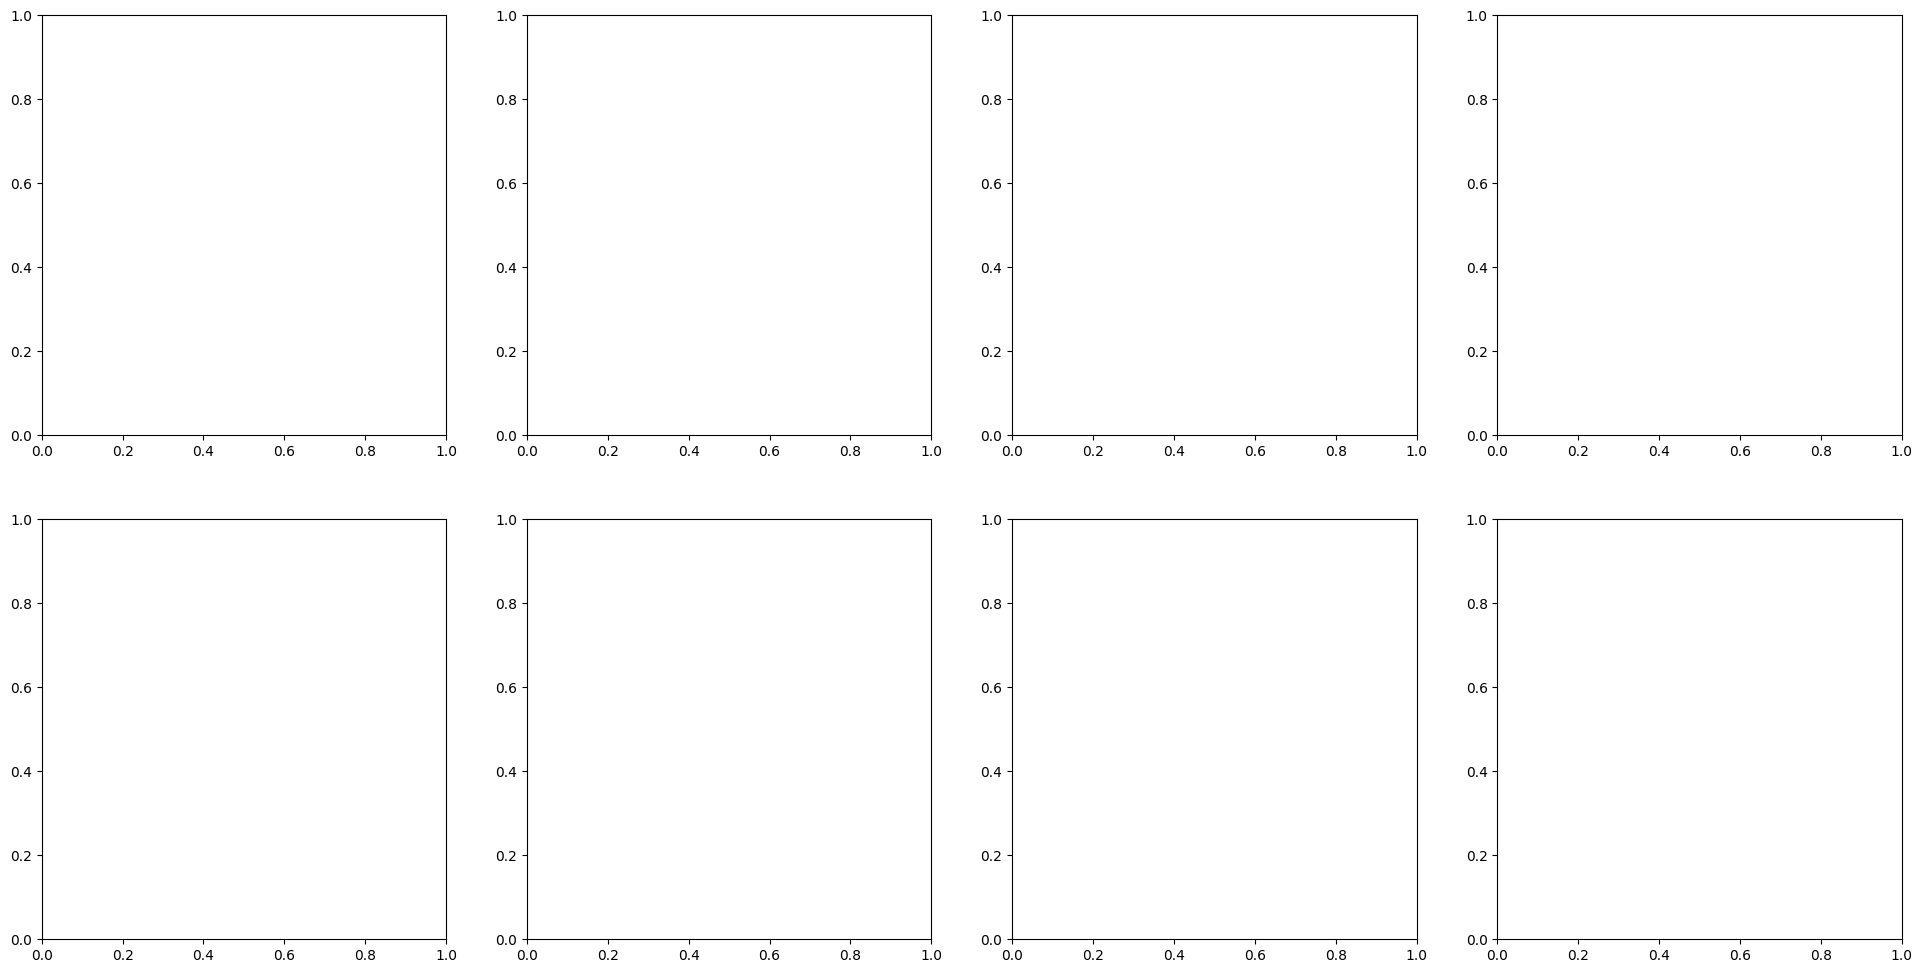

In [21]:
visualize_layerwise_embeddings(hidden_states=outputs.hidden_states[1:],
                               masks=tokenized_inputs['attention_mask'],
                               labels=labels,
                               epoch=0,
                               title="Something",
                               layers_to_visualize=[0,1,2,3,8,9,10,11])